# Predicting Taxi Orders

# Content

* [Introduction](#intro)
* [Initialization](#initialization)
* [Data Exploration](#data_exploration)
	* [Conclusion](#conclusion)
* [Data Preparation](#data_preparation)
	* [Conclusion](#conclusion)
* [Model Analysis](#model_analysis)
	* [Rolling Mean](#rolling_mean)
	* [Trends and Seasonality](#trends_seasonality)
	* [Autocorrelation Plots](#autocorrelation_plots)
* [Model Training](#model_training)
	* [Feature Engineering](#feature_egineering)
	* [Training](#training)
	* [Linear Regression](#linear_regression)
	* [Random Forest Regressor](#rfr)
	* [KNeighbors Regressor](#KNN)
	* [CatBoost Regressor](#cbr)
	* [XGBoost Regressor](#xgb)
	* [LightGBM Regressor](#gbm)
	* [Conclusion](#conclusion)
* [Model Analysis](#model_analysis)
	* [Conclusion](#conclusion)
* [Findings](#findings)


## Introduction 

Sweet Lift Taxi company has collected historical data on taxi orders at airports. The company wants to attract more drivers during peak hours. To do this, we need to build a model to predict the amount of taxi orders for the next hour. 

**Data Description:**
* `datetime`
* `num_orders` - number of orders

**Objectives:**
* Train different models with different hyperparameters 
* Predict amount of taxi orders for the next hour
* Test data using the test sample and provide a conclusion  

## Initialization

In [1]:
# Loading all libraries 
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

!pip install catboost
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 76.6 MB 43 kB/s 


In [2]:
# Loading the data
try:
  df = pd.read_csv('taxi.csv')
except:
  df = pd.read_csv('/datasets/taxi.csv')

## Data Exploration 

Description of data:
* `datetime`
* `num_order` - number of orders

In [3]:
# Obtaining first five rows of the table
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Obtaining the number of rows and columns
shape = df.shape
print('The table has {} rows and {} columns'.format(shape[0], shape[1]))

The table has 26496 rows and 2 columns


In [5]:
# Obtaining general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Since there are 26,496 rows per column, there is no missing values in this table. 

In [6]:
# Checking for duplicates
df.duplicated().sum()

0

### Conclusion 

Our dataset contains 26,496 rows and 2 columns. Since each column contains 26,496 rows, there is no missing data in the table. Our dataframe also contains no duplicates. All column names follow good rules of style. 

Since we will be working with time series, we will convert the `datetime` column from object type to date time format, and prepare our data before training. 

## Data Preparation

In [7]:
# Converting data type
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

# Checking to see if datetime has been properly converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Now that `datetime` has been properly converted to datetime format, we will set the index to `datetime` and check if the dates and times are in chronological order.

In [8]:
# Setting datetime to index
df = df.set_index('datetime')

# Checking to see if datetime is in chronological order
print(df.index.is_monotonic)
df.info()


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Since the attribute returned true, the datetime index is in chronological order.



In [9]:
# Visualizing time series
fig = px.line(df, title='Number of Taxi Orders from March 2018 to September 2018', template='simple_white', labels=dict(index='Datetime', value='Number of Orders'))
fig.show()


To inspect how our data behaves, we will resample our data by 1 hour and aggregate it using the sum.

In [10]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Conclusion

We prepared our data by converting the `datetime` column from object type to datetime format. We set the index to datetime and confirmed that the dates and times were in chronological order. We visualized our time series and resampled our data by 1 hour. 
 
Now we can analyze our data using trends and seasonality. 


## Model Analysis

### Rolling Mean

We will create a rolling window with a specified size and perform calculations on the data in this window.

In [11]:
# Rolling mean
df['rolling_mean'] = df.rolling(25).mean()
df = df.dropna()
df.head()

,num_orders,rolling_mean
datetime,,
2018-03-02 00:00:00,90,58.16
2018-03-02 01:00:00,120,58.00
2018-03-02 02:00:00,75,57.60
2018-03-02 03:00:00,64,57.32
2018-03-02 04:00:00,20,55.48


In [13]:
# Resampling by 1 day
df_ = df.resample('1D').sum()

In [14]:
# Rolling mean plot
fig = px.line(df_, title='Rolling Mean Plot (Window Size = 25)', labels=dict(index='Datetime', value='Number of Orders'))
fig.show()


From our rolling mean plot with a window size of 25, we can see a steady increase (upward trend) in the number of orders from April 2018 to August 2018. This means there is an increase in orders over the period of time.  

### Trends and Seasonality 

Text(0.5, 1.0, 'Trend')

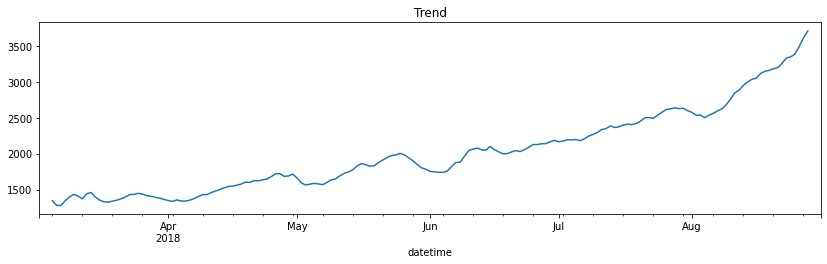

In [17]:
# Decomposing time series into trend and seasonal components 
decomposed = seasonal_decompose(df_['num_orders'], model='additive')

# Plotting trend
plt.figure(figsize=(14,12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')



We can see an obward trend in the number of taxi orders from March 2018 to September 2018.

Text(0.5, 1.0, 'Seasonality')

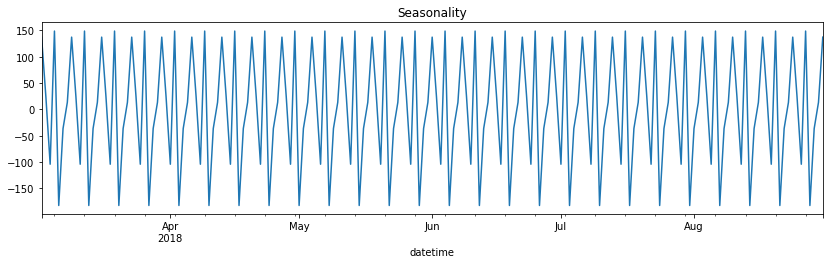

In [18]:
# Plotting seasonality
plt.figure(figsize=(14,12))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Seasonality illustrates true repetiton. We can see that the amplitudes form a pattern that repeat from one seasonal period to the next. 

Text(0.5, 1.0, 'Residuals')

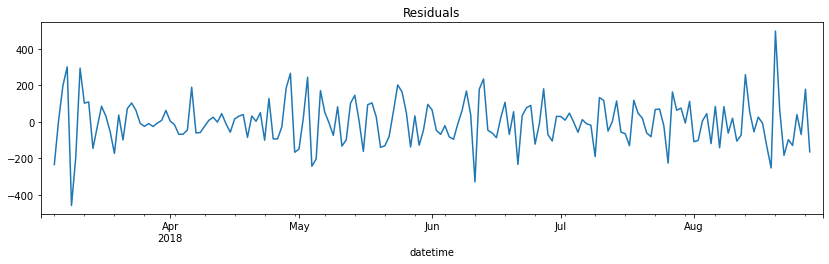

In [19]:
# Plotting residuals
plt.figure(figsize=(14,12))

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

The residual plot illustrates computational artifacts. Now we will see how seasonliaty varies over the weekend. 

Text(0.5, 1.0, 'Seasonal Plot for the First Two Weeks of April 2018')

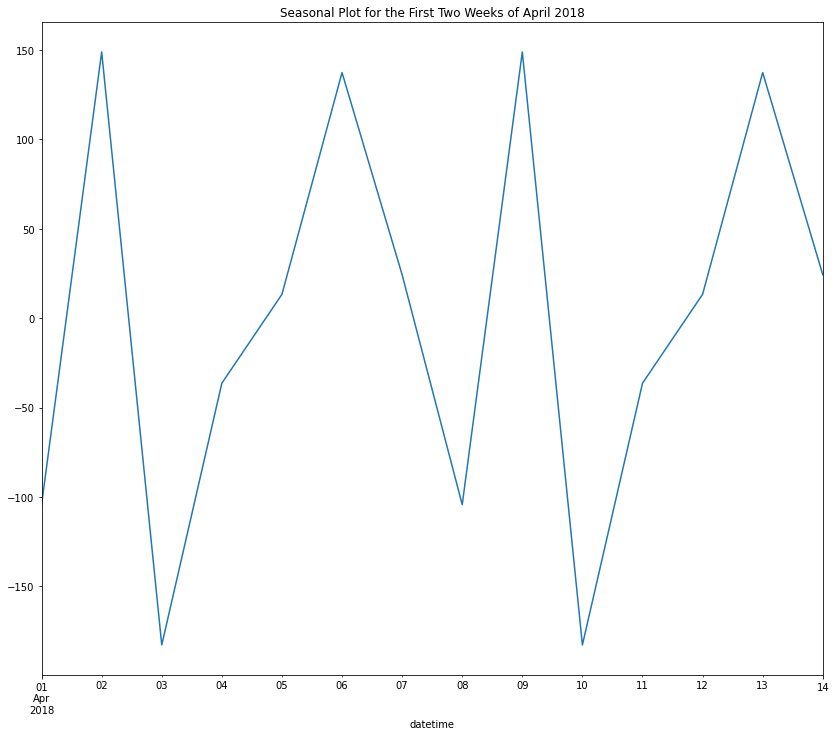

In [20]:
# Plotting seasonality for the first 2 weeks of April 2018
decomposed.seasonal['2018-04-01':'2018-04-14'].plot(figsize=(14,12))
plt.title('Seasonal Plot for the First Two Weeks of April 2018')


From our seasonal plot above, we see that taxi orders peaked on April 2 (Monday), April 6 (Friday), April 9 (Monday), and April 13 (Friday). This makes sense since the beginning the week is when most poeple go back to work and Fridays are the day when most people go out to signify the start of their weekend. 

### Autocorrelation Plots

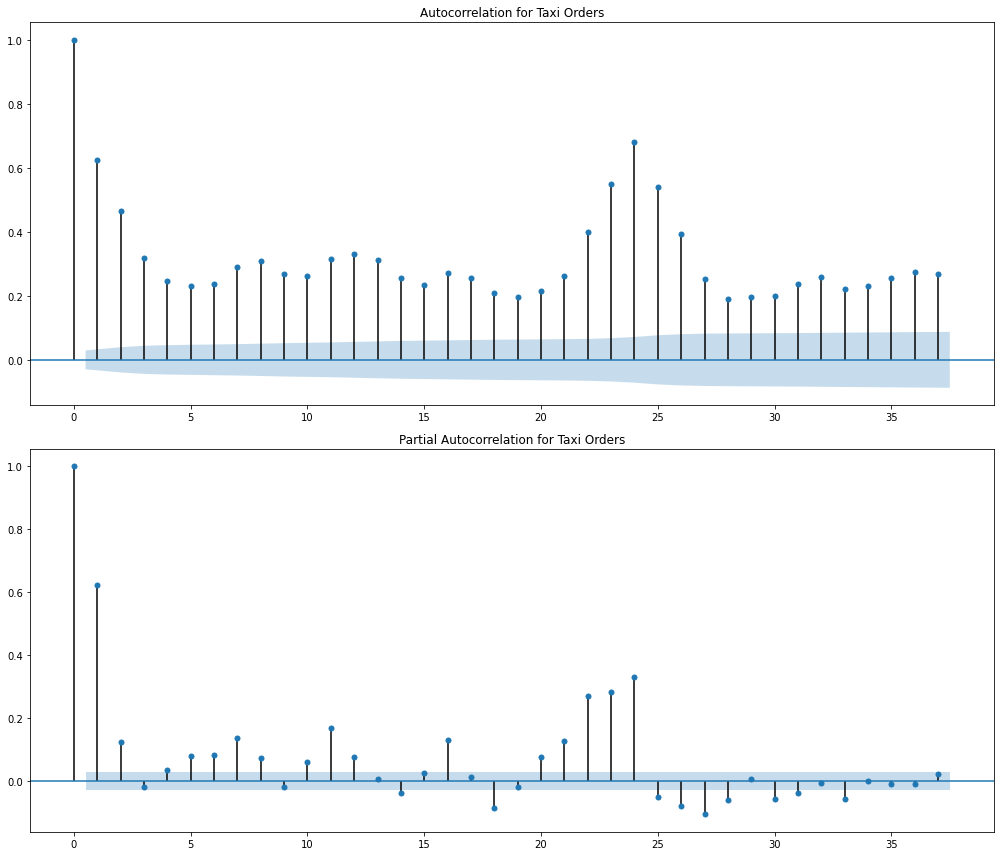

In [21]:
# Plotting correlations
fig, ax = plt.subplots(2, figsize=(14,12))

plot_acf(df['num_orders'], title='Autocorrelation for Taxi Orders', ax=ax[0])

plot_pacf(df['num_orders'], title='Partial Autocorrelation for Taxi Orders', ax=ax[1])

plt.tight_layout()

The autocorrelation function (ACF) shows the value of correlation coefficient between the series and its lagged values. In the ACF plot, we can see that there are significant autocorrelations above the 95% cofidence interval. The correlations decrease as lag increases. 

In contrast, the partial autocorrelation function (PACF) looks at the correlation between the residuals and the following lag value. We can see significant correlations at the first and second lag, followed by correlations that are not significant.

## Model Training

### Feature Egineering

We will add four new calendar features to our table: year, month, day, and day of the week. We will also calculate lag values and rolling average. 

In [22]:
# Creating function to add new features
def make_features(df, max_lag, rolling_mean_size):
  df['month'] = df.index.month
  df['day'] = df.index.day
  df['dayofweek'] = df.index.dayofweek
  df['hour'] = df.index.hour

  for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

  df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [23]:
# Creating new features
df = pd.DataFrame(df)
make_features(df, 12, 10)
df.head()

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,NaN,3,2,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 01:00:00,120,NaN,3,2,4,1,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 02:00:00,75,NaN,3,2,4,2,120.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 03:00:00,64,NaN,3,2,4,3,75.0,120.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-02 04:00:00,20,NaN,3,2,4,4,64.0,75.0,120.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Dropping null values from df
df = df.dropna()
df.head()

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-02 12:00:00,36,42.4,3,2,4,12,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0
2018-03-02 13:00:00,45,38.5,3,2,4,13,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0
2018-03-02 14:00:00,44,36.6,3,2,4,14,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0
2018-03-02 15:00:00,59,39.0,3,2,4,15,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0
2018-03-02 16:00:00,82,43.8,3,2,4,16,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0


### Training

In [25]:
# Split the data into train and testing sets
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

display(train.shape)
display(test.shape)

(3942, 18)

(438, 18)

In [26]:
# Declaring variables for features and target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [27]:
# Time series split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [28]:
%%time

# Forecasting time series without training
pred_previous = test.shift(fill_value=train['num_orders'].iloc[-1])
print('RMSE =', np.sqrt(mean_squared_error(test, pred_previous)))

RMSE = 50.28380020608929
CPU times: user 7.72 ms, sys: 0 ns, total: 7.72 ms
Wall time: 9.01 ms


### Linear Regression

In [29]:
%%time

# Linear regression model
lr = LinearRegression()
lr.fit(features_train, target_train)

CPU times: user 6.69 ms, sys: 6.79 ms, total: 13.5 ms
Wall time: 35.5 ms


In [30]:
%%time

# Making predictions 
lr_predict = lr.predict(features_test)

CPU times: user 3.82 ms, sys: 0 ns, total: 3.82 ms
Wall time: 4.26 ms


In [31]:
%%time 

# Calculating RMSE 
print('RMSE =', np.sqrt(mean_squared_error(target_test, lr_predict)))

RMSE = 52.50142746632777
CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 4.52 ms


### Random Forest Regressor

In [ ]:
%%time

# Tuning hyperparameters 
grid = {'n_estimators':[3,7,10,25,50],
        'max_depth':[None,2,6,10,14],
        'min_samples_leaf':[2,3,8]}

rfr = RandomForestRegressor(random_state=12345)

grid_search_rfr = GridSearchCV(estimator=rfr, param_grid=grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search_rfr.fit(features_train, target_train)

print('The best hyperparameters are: {}'.format(grid_search_rfr.best_params_))

The best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}
CPU times: user 1min, sys: 180 ms, total: 1min
Wall time: 1min 8s


In [ ]:
%%time

# Random forest regressor model with tuned hyperparameters
rfr_model = RandomForestRegressor(**grid_search_rfr.best_params_)
rfr_model.fit(features_train, target_train)

CPU times: user 1.03 s, sys: 6.96 ms, total: 1.03 s
Wall time: 1.04 s


In [ ]:
%%time

# Making predictions
rfr_predict = rfr_model.predict(features_test)

CPU times: user 8.04 ms, sys: 2.99 ms, total: 11 ms
Wall time: 13.9 ms


In [ ]:
%%time

# Calculating RMSE
print('RMSE =', np.sqrt(mean_squared_error(target_test, rfr_predict)))

RMSE = 44.459832316392365
CPU times: user 730 µs, sys: 0 ns, total: 730 µs
Wall time: 614 µs


### KNeighbors Regressor

In [ ]:
%%time

# Tuning hyperparameters
grid = {'n_neighbors':[3,5,11,19],
        'weights':['uniform','distance']}

knn = KNeighborsRegressor()

grid_search_knn = GridSearchCV(estimator=knn, param_grid=grid, verbose=1, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
grid_search_knn.fit(features_train, target_train)

print('The best hyperparameters are: {}'.format(grid_search_knn.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
The best hyperparameters are: {'n_neighbors': 19, 'weights': 'distance'}
CPU times: user 274 ms, sys: 53.2 ms, total: 327 ms
Wall time: 2.24 s


In [ ]:
%%time

# KNeighbors regressor model with tuned hyperparameters
knn_model = KNeighborsRegressor(**grid_search_knn.best_params_)
knn_model.fit(features_train, target_train)

CPU times: user 8.21 ms, sys: 23 µs, total: 8.23 ms
Wall time: 11.6 ms


In [ ]:
%%time

# Making predictions
knn_predict = knn_model.predict(features_test)

CPU times: user 15.9 ms, sys: 1e+03 µs, total: 16.9 ms
Wall time: 22.1 ms


In [ ]:
%%time

# Calculating RMSE
print('RMSE =', np.sqrt(mean_squared_error(target_test, knn_predict)))

RMSE = 60.02066046147648
CPU times: user 890 µs, sys: 0 ns, total: 890 µs
Wall time: 729 µs


### CatBoost Regressor

In [ ]:
%%time 

# Tuning hyperparameters
grid = {'learning_rate':[0.001, 0.005, 0.01],
        'depth':[4,7,9],
        'l2_leaf_reg':[1,5,7,9]}

cb = CatBoostRegressor(iterations=100, logging_level='Silent', loss_function='RMSE', early_stopping_rounds=55, random_state=12345)

grid_search_cb = GridSearchCV(estimator=cb, param_grid=grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search_cb.fit(features_train, target_train)

print('The best hyperparameters are: {}'.format(grid_search_cb.best_params_))

The best hyperparameters are: {'depth': 9, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
CPU times: user 2min 12s, sys: 4.78 s, total: 2min 17s
Wall time: 1min 15s


In [ ]:
%%time

# Catboost regressor model with hyperparameters tuned
cbr = CatBoostRegressor(**grid_search_cb.best_params_)
cbr.fit(features_train, target_train)

0:	learn: 38.4893698	total: 10.7ms	remaining: 10.7s
1:	learn: 38.3080745	total: 21.5ms	remaining: 10.7s
2:	learn: 38.1073305	total: 33.4ms	remaining: 11.1s
3:	learn: 37.9195819	total: 43.8ms	remaining: 10.9s
4:	learn: 37.7243325	total: 54.1ms	remaining: 10.8s
5:	learn: 37.5239239	total: 64.9ms	remaining: 10.8s
6:	learn: 37.3248601	total: 75.4ms	remaining: 10.7s
7:	learn: 37.1295193	total: 86.1ms	remaining: 10.7s
8:	learn: 36.9536388	total: 98.8ms	remaining: 10.9s
9:	learn: 36.7797919	total: 112ms	remaining: 11.1s
10:	learn: 36.6070337	total: 123ms	remaining: 11s
11:	learn: 36.4341977	total: 133ms	remaining: 11s
12:	learn: 36.2553431	total: 144ms	remaining: 10.9s
13:	learn: 36.0739541	total: 154ms	remaining: 10.8s
14:	learn: 35.9012800	total: 168ms	remaining: 11s
15:	learn: 35.7286875	total: 178ms	remaining: 11s
16:	learn: 35.5497628	total: 189ms	remaining: 10.9s
17:	learn: 35.3839525	total: 200ms	remaining: 10.9s
18:	learn: 35.2181738	total: 215ms	remaining: 11.1s
19:	learn: 35.0563587

In [ ]:
%%time

# Making predictions
cbr_predict = cbr.predict(features_test)

CPU times: user 8.18 ms, sys: 5.01 ms, total: 13.2 ms
Wall time: 11.2 ms


In [ ]:
%%time 

# Calculating RMSE 
print('RMSE =', np.sqrt(mean_squared_error(target_test, cbr_predict)))

RMSE = 45.49156854084817
CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 1.94 ms


### XGBoost Regressor

In [ ]:
%%time

# Tuning hyperparameters
grid = {'learning_rate':[0.001, 0.007, 0.01, 0.03],
        'max_depth':[2,5,7,10],
        'n_estimators':[30,50,70,120]}

xgb = XGBRegressor(random_state=12345)

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
grid_search_xgb.fit(features_train, target_train)

print('The best hyperparameters are: {}'.format(grid_search_xgb.best_params_))

[23:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best hyperparameters are: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 120}
CPU times: user 2.62 s, sys: 118 ms, total: 2.74 s
Wall time: 51.7 s


In [ ]:
%%time

# XGBoost regressor model with tuned hyperparameters
xgbr = XGBRegressor(**grid_search_xgb.best_params_)
xgbr.fit(features_train, target_train)

[23:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 482 ms, sys: 4.9 ms, total: 487 ms
Wall time: 487 ms


In [ ]:
%%time 

# Making predictions
xgbr_predict = xgbr.predict(features_test)

CPU times: user 5.08 ms, sys: 2 µs, total: 5.08 ms
Wall time: 4.1 ms


In [ ]:
%%time 

# Calculating RMSE
print('RMSE =', np.sqrt(mean_squared_error(target_test, xgbr_predict)))

RMSE = 48.107086464978494
CPU times: user 1.12 ms, sys: 4 µs, total: 1.13 ms
Wall time: 1.01 ms


### LightGBM Regressor

In [ ]:
%%time 

# Tuning hyperparameters
grid = {'learning_rate':[0.001, 0.03, 0.05, 0.1],
        'n_estimators':[25,40,70,120],
        'num_leaves':[5,10,12,21,30]}

lgbm = LGBMRegressor(random_state=12345)

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
grid_search_lgbm.fit(features_train, target_train)

print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

The best hyperparameters are: {'learning_rate': 0.05, 'n_estimators': 120, 'num_leaves': 30}
CPU times: user 1.42 s, sys: 61.5 ms, total: 1.48 s
Wall time: 16 s


In [ ]:
%%time

# LightGBM regressor model with tuned hyperparameters
lgbmr = LGBMRegressor(**grid_search_lgbm.best_params_)
lgbmr.fit(features_train, target_train)

CPU times: user 161 ms, sys: 7.02 ms, total: 168 ms
Wall time: 169 ms


In [ ]:
%%time

# Making predictions
lgbmr_predict = lgbmr.predict(features_test)

CPU times: user 7.97 ms, sys: 2 µs, total: 7.97 ms
Wall time: 8.06 ms


In [ ]:
%%time

# Calculating RMSE
print('RMSE =', np.sqrt(mean_squared_error(target_test, lgbmr_predict)))

RMSE = 42.68039296342652
CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 2.07 ms


### Conclusion 

We added four new calendar features to our dataframe: year, month, day, and day of the week. We also added lag values and rolling average. The data was then split into training and test sets, with the test sample being 10% of the initial dataset. Since there is a fundamental difference between time series data and other types, observations’ sequential order is important int time series. Thus, shuffling or any other kind of sampling that disrupts the successive order is not used. To split the data in such a way that preserves the important attributes, we used TimeSeriesSplit. 

We first forecasted time series without training by using the previous values of the series and obtained an RMSE of 5.22. We then trained six different models: linear regression, random forest regressor, KNeighbors regressor, Catboost regressor, XGBoost regressor, and LightGBM regressor. The metric used to evaluate the models was the root mean square error (RMSE). The RMSE is the standard deviation of the residuals (or prediction errors). Lower values of RMSE tend to indicate a better fit. Since linear regression is not great for hyperparameter tuning, we fitted the model and found that the RMSE was 6.37. We used GridSearchCV to perform an exhaustive search over specified parameter values to tune our hyperparameters for the random forest regressor, KNeighbors regressor, Catboost regressor, XGBoost regressor, and LightGBM regressor. After finding the best hyperparameters to use for each model, we fitted the model and calculated the RMSE. For the random forest regressor, we obtained a RMSE score of 6.48. The KNeighbors regressor obtained a RMSE score of 6.73. The Catboost Regressor obtained an RMSE score of 6.42. The XGBoost regressor obtained an RMSE score of 6.51. The LightGBM regressor obtained a RMSE score of 6.44. 


## Model Analysis

In [ ]:
# Creating dataframe to compare diffent performance of models 
model = ['LinearRegressor', 'RandomForestRegressor', 'KNeighbors Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'LightGBM Regressor']
rmse = [6.37, 6.48, 6.73, 6.42, 6.51, 6.44]
tune_time = [0, 52.3, 2.28, 119, 63, 16.2]
model_time = [.00949, .784, .0127, .0132, .505, .0546]
pred_time = [.00347, .0134, .0279, .0114, .00775, .0045]
models = pd.DataFrame(data = zip(model, rmse, tune_time, model_time, pred_time), columns = ['model', 'rmse_score', 'hyperparameter_tuning_time', 'model_run_time', 'model_prediction_time'])

display(models)

,model,rmse_score,hyperparameter_tuning_time,model_run_time,model_prediction_time
0,LinearRegressor,6.37,0.00,0.00949,0.00347
1,RandomForestRegressor,6.48,52.30,0.78400,0.01340
2,KNeighbors Regressor,6.73,2.28,0.01270,0.02790
3,CatBoost Regressor,6.42,119.00,0.01320,0.01140
4,XGBoost Regressor,6.51,63.00,0.50500,0.00775
5,LightGBM Regressor,6.44,16.20,0.05460,0.00450


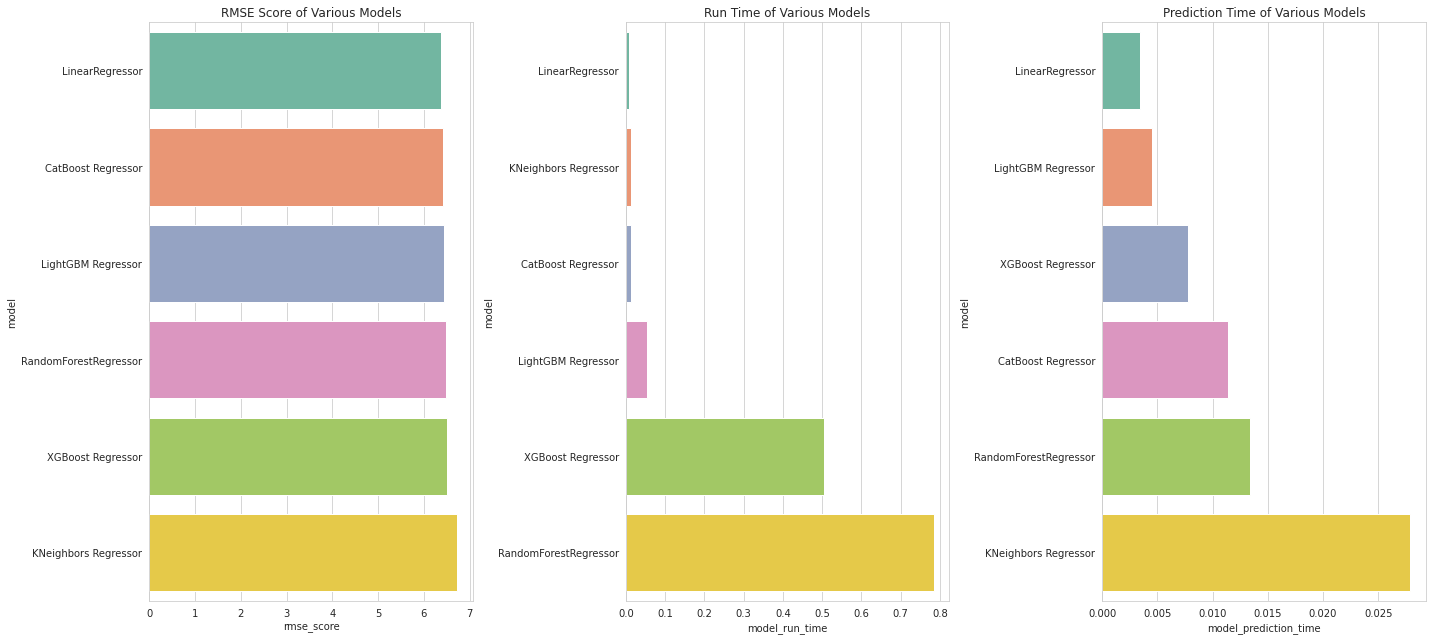

In [ ]:
# Plotting performance metrics
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 3, figsize=(20,9))

sns.barplot(data = models.sort_values('rmse_score'), 
            y = 'model',
            x = 'rmse_score',
            orient = 'h', 
            palette ='Set2', 
            ax=ax[0])
ax[0].set_title('RMSE Score of Various Models')


sns.barplot(data=models.sort_values(by='model_run_time'),
            y ='model',
            x = 'model_run_time', 
            orient = 'h', 
            palette = 'Set2', 
            ax = ax[1])
ax[1].set_title('Run Time of Various Models')

sns.barplot(data = models.sort_values(by='model_prediction_time'),
            y = 'model',
            x = 'model_prediction_time',
            orient = 'h',
            palette = 'Set2',
            ax = ax[2])
ax[2].set_title('Prediction Time of Various Models')

plt.tight_layout()
plt.show()

### Conclusion 

Our linear regression model had the lowest RMSE score of 6.37, while our KNeighbors regressor model had the highest RMSE score of 6.73. Our CatBoost regressor model took the longest to tune hyperparameters using GridSearchCV, while the KNeighbors regressor model took the least time. The XGBoost regressor took the least time to predict the target. Since the metric used to evaluate our models was RMSE, the linear regression model outperformed the other models. 

## Findings

Since we are working with time series, we set the index to datetime and confirmed that the dates and times were in chronological order. To inspect how our data behaves, we will resamples our data by 1 hour, aggregates it using the sum, and visualized it. We plotting a rolling mean plot with a window size of 25 and saw a steady increase (upward trend) in the number of orders from April 2018 to August 2018. 

We decomposed our time series into trend and seasonal components and observed an upward trend in the number of taxi orders from March 2018 to September 2018. Since seasonality illustrates true repitition, we saw that the amplitudes from our plot formed a pattern that repeated from one seasonal period to the next. To further inspect how seasonality varies over the weekend, we plotted the first two weeks of April 2018 and saw that taxi orders peaked on April 2 (Monday), April 6 (Friday), April 9 (Monday), and April 13 (Friday). This made sense since the beginning of the week signifies when most people go back to work and Fridays signifies the beginning of the weekend where most people go out. We also plotted the autocorrelation function (ACF) and the partial autocorrelation function (PACF). In the ACF plot, we saw a significant autocorrelations above the 95% confidence interval. In the PACF plot, we saw significant correlations at the first and second lag, followed by correlations that were less significant. 

We added lag values, rolling average values, and four new calendar features (year, month, day, and day of the week) to our DataFrame. The data was then split into training and test sets, with the test sample being 10% of the initial dataset. To split the data in such a way that preserves the important attributes, we used TimeSeriesSplit. We first forecasted time series without training by using the previous values of the series and obtained an RMSE of 5.22. We then trained six different models: linear regression, random forest regressor, KNeighbors regressor, Catboost regressor, XGBoost regressor, and LightGBM regressor. The metric used to evaluate the models was the root mean square error (RMSE). . Since linear regression is not great for hyperparameter tuning, we just fitted the model and calculated RMSE. We used the GridSearchCV to perform an exhaustive search over specified parameter values to tune our hyperparameters for the  random forest regressor, KNeighbors regressor, Catboost regressor, XGBoost regressor, and LightGBM regressor.
* RMSE score for the linear regression model: 6.37 
* RMSE score for random forest regressor: 6.48
* RMSE score for KNeighbors regressor: 6.73
* RMSE score for CatBoost regressor: 6.42
* RMSE score for XGBoost regressor: 6.51
* RMSE score for LightGBM regressor: 6.44

We analyzed the speed and quality of the models we trained.
* Our linear regression model had the lowest RMSE score of 6.37, while the KNeighbors regressor model had the highest RMSE score of 6.73 
* Our CatBoost regressor model took the longest to tune hyperparameters using GridSearchCV, while the KNeighbors regressor model took the least time. 
* The KNeighbors regressor model to the least time to fit the model after hyperparameter tuning and the random forest regressor model took the longest time to fit the model after hyperparameter tuning
* The XGBoost regressor took the least time to predict the target after hyperparmeter tuning 

Since the metric used to evaluate our models was RMSE, the linear regression model outperformed the other models.  A summary of the models we trained is shown below:



| Model | RMSE Score | Hyperparameter Tuning Time (sec) | Model Run Time (sec)| Model Prediction Time (sec) | 
| --- | --- | --- | ---| ---|
| Linear Regressor | 6.37 | N/A | 9.49 ms | 3.47 ms
| Random Forest Regressor | 6.48 | 52.3 s | 784 ms | 13.4 ms
| KNeighbors Regressor | 6.73 | 2.28 s | 12.7 ms | 27.9 ms
| CatBoost Regressor | 6.42 | 119 s | 13.2 s | 11.4 ms
| XGBoost Regressor | 6.51 | 63 s | 505 ms| 7.75 ms
| LightGBM Regressor | 6.44 | 16.2 s | 54.6 ms| 4.5 ms